In [3]:
import os
import time
import numpy as np
import sys
from torch.utils.data import DataLoader

notebook_dir = os.getcwd()
project_root_path = os.path.dirname(notebook_dir)
sys.path.insert(0, project_root_path)

from config import PROJECT_ROOT

from src.preprocessing import *
from src.utils import get_filename_to_id_mapping
from src.dataset import ImageConceptDataset

In [4]:
# LOAD AND TRANSFORM IMAGES
input_dir = os.path.join(PROJECT_ROOT, 'images')
resol = 299
training = True
images_file = os.path.join(PROJECT_ROOT, 'data', 'images.txt')

image_tensors, image_paths = load_and_transform_images(input_dir, images_file, resol, training, batch_size=32, verbose=True, dev=False)

Using TRAINING transformations:
Found 11788 images.
Processing in 369 batches of size 32 (for progress reporting)...


Processing batches: 100%|██████████| 369/369 [01:20<00:00,  4.58it/s]


Finished processing.
Successfully transformed: 11788 images.


In [ ]:
# CREATE CONCEPT LABELS MATRIX
concept_labels_file = os.path.join(PROJECT_ROOT, 'data', 'image_concept_labels.txt')

concept_labels, uncertainty_matrix = encode_image_concepts(concept_labels_file, verbose=True)

Found 11788 unique images.
Found 312 unique concepts.
Generated concept matrix with shape: (11788, 312)


In [7]:
# CREATE IMAGE LABELS MATRIX
labels_file = os.path.join(PROJECT_ROOT, 'data', 'image_class_labels.txt')
classes_file = os.path.join(PROJECT_ROOT, 'data', 'classes.txt')

image_labels = one_hot_encode_labels(labels_file, classes_file, verbose=True)

Found 200 classes.
Found labels for 11788 images.
Generated one-hot matrix with shape: (11788, 200)


In [8]:
# CREATE TRAIN TEST SPLIT USING TXT FILE
split_file = os.path.join(PROJECT_ROOT, 'data', 'train_test_split.txt')

split_data = split_datasets(split_file, concept_labels, image_labels, image_tensors)

train_concepts = split_data['train_concepts']
test_concepts = split_data['test_concepts']

train_img_labels = split_data['train_img_labels']
test_img_labels = split_data['test_img_labels']

train_tensors = split_data['train_tensors']
test_tensors = split_data['test_tensors']

print(f"Train set size: {len(train_tensors)} tensors, {train_concepts.shape[0]} concepts, {train_img_labels.shape[0]} labels")
print(f"Test set size:  {len(test_tensors)} tensors, {test_concepts.shape[0]} concepts, {test_img_labels.shape[0]} labels")

Split complete: 5994 train images, 5794 test images.
Train set size: 5994 tensors, 5994 concepts, 5994 labels
Test set size:  5794 tensors, 5794 concepts, 5794 labels


In [ ]:
import numpy as np
import matplotlib.pyplot as plt # For plotting histogram

# --- Code to Analyze Attribute Imbalance ---

print("\nAnalyzing attribute imbalance in the training set...")

# Ensure train_concepts is a NumPy array
if not isinstance(train_concepts, np.ndarray):
    try:
        train_concepts_np = np.array(train_concepts)
        print("Converted train_concepts to NumPy array.")
    except Exception as e:
        print(f"Error: Could not convert train_concepts to NumPy array. Please ensure it's defined. Details: {e}")
        # Stop execution here or handle appropriately
        raise ValueError("train_concepts is not a NumPy array or convertible.")
else:
    train_concepts_np = train_concepts

if train_concepts_np.ndim != 2:
     raise ValueError(f"Expected train_concepts_np to be 2D, but got shape {train_concepts_np.shape}")

num_train_samples, num_attributes = train_concepts_np.shape
print(f"Training set shape: {num_train_samples} samples, {num_attributes} attributes.")

attribute_imbalance_stats = []

# --- Optional: Load attribute names for better readability ---


Analyzing attribute imbalance in the training set...
Training set shape: 5994 samples, 312 attributes.


In [ ]:
attribute_names = []
try:
    concept_names_path = os.path.join(PROJECT_ROOT, 'data', 'concepts.txt')
    with open(concept_names_path, 'r') as f:
        attribute_names = [line.strip().split()[-1] for line in f] # Assumes format "idx name"
    if len(attribute_names) != num_attributes:
        print(f"Warning: Loaded {len(attribute_names)} names, but expected {num_attributes}. Indices will be used.")
        attribute_names = [f"Attr_{i}" for i in range(num_attributes)]
except NameError:
    print("Warning: concept_names_path not defined. Using generic attribute indices.")
    attribute_names = [f"Attr_{i}" for i in range(num_attributes)]
except FileNotFoundError:
    print(f"Warning: Concepts file not found at {concept_names_path}. Using generic attribute indices.")
    attribute_names = [f"Attr_{i}" for i in range(num_attributes)]
except Exception as e:
     print(f"Warning: Error loading concept names: {e}. Using generic attribute indices.")
     attribute_names = [f"Attr_{i}" for i in range(num_attributes)]
# --------------------------------------------------------------

for i in range(num_attributes):
    attribute_column = train_concepts_np[:, i]

    # Count occurrences of 0 and 1
    counts = np.bincount(attribute_column.astype(int), minlength=2) # Ensures counts for 0 and 1 exist
    num_neg = counts[0]
    num_pos = counts[1]

    # Calculate percentage positive
    percent_pos = (num_pos / num_train_samples) * 100 if num_train_samples > 0 else 0

    # Calculate ratio (handle division by zero)
    ratio_neg_pos = num_neg / num_pos if num_pos > 0 else float('inf') # Negatives per Positive

    attribute_imbalance_stats.append({
        'index': i,
        'name': attribute_names[i],
        'num_pos': num_pos,
        'num_neg': num_neg,
        'percent_pos': percent_pos,
        'ratio_neg_pos': ratio_neg_pos
    })

# --- Summarize the results ---

# Sort by percentage positive (most skewed first)
attribute_imbalance_stats.sort(key=lambda x: abs(x['percent_pos'] - 50), reverse=True)

print("\nMost Imbalanced Attributes (by % positive deviated from 50%):")
for k in range(min(10, num_attributes)): # Print top 10 most skewed
    stats = attribute_imbalance_stats[k]
    print(f"  Index {stats['index']:<3d} ({stats['name']}): "
          f"{stats['percent_pos']:.2f}% Positive ({stats['num_pos']}/{num_train_samples}), "
          f"Ratio Neg/Pos: {stats['ratio_neg_pos']:.2f}")



Most Imbalanced Attributes (by % positive deviated from 50%):
  Index 137 (has_eye_color::purple): 0.13% Positive (8/5994), Ratio Neg/Pos: 748.25
  Index 271 (has_leg_color::green): 0.17% Positive (10/5994), Ratio Neg/Pos: 598.40
  Index 142 (has_eye_color::green): 0.20% Positive (12/5994), Ratio Neg/Pos: 498.50
  Index 141 (has_eye_color::olive): 0.22% Positive (13/5994), Ratio Neg/Pos: 460.08
  Index 286 (has_bill_color::green): 0.23% Positive (14/5994), Ratio Neg/Pos: 427.14
  Index 281 (has_bill_color::purple): 0.27% Positive (16/5994), Ratio Neg/Pos: 373.62
  Index 108 (has_breast_color::purple): 0.30% Positive (18/5994), Ratio Neg/Pos: 332.00
  Index 143 (has_eye_color::pink): 0.32% Positive (19/5994), Ratio Neg/Pos: 314.47
  Index 270 (has_leg_color::olive): 0.32% Positive (19/5994), Ratio Neg/Pos: 314.47
  Index 200 (has_belly_color::purple): 0.33% Positive (20/5994), Ratio Neg/Pos: 298.70


In [12]:

print("\nLeast Imbalanced Attributes (closest to 50%):")
for k in range(min(10, num_attributes)): # Print top 10 least skewed
    stats = attribute_imbalance_stats[-(k+1)]
    print(f"  Index {stats['index']:<3d} ({stats['name']}): "
          f"{stats['percent_pos']:.2f}% Positive ({stats['num_pos']}/{num_train_samples}), "
          f"Ratio Neg/Pos: {stats['ratio_neg_pos']:.2f}")



Least Imbalanced Attributes (closest to 50%):
  Index 218 (has_size::small_(5_-_9_in)): 51.25% Positive (3072/5994), Ratio Neg/Pos: 0.95
  Index 235 (has_shape::perching-like): 48.57% Positive (2911/5994), Ratio Neg/Pos: 1.06
  Index 54  (has_breast_pattern::solid): 55.21% Positive (3309/5994), Ratio Neg/Pos: 0.81
  Index 289 (has_bill_color::black): 43.93% Positive (2633/5994), Ratio Neg/Pos: 1.28
  Index 151 (has_bill_length::shorter_than_head): 56.17% Positive (3367/5994), Ratio Neg/Pos: 0.78
  Index 20  (has_wing_color::black): 43.21% Positive (2590/5994), Ratio Neg/Pos: 1.31
  Index 244 (has_belly_pattern::solid): 57.37% Positive (3439/5994), Ratio Neg/Pos: 0.74
  Index 35  (has_upperparts_color::black): 39.02% Positive (2339/5994), Ratio Neg/Pos: 1.56
  Index 51  (has_underparts_color::white): 38.96% Positive (2335/5994), Ratio Neg/Pos: 1.57
  Index 6   (has_bill_shape::all-purpose): 38.05% Positive (2281/5994), Ratio Neg/Pos: 1.63


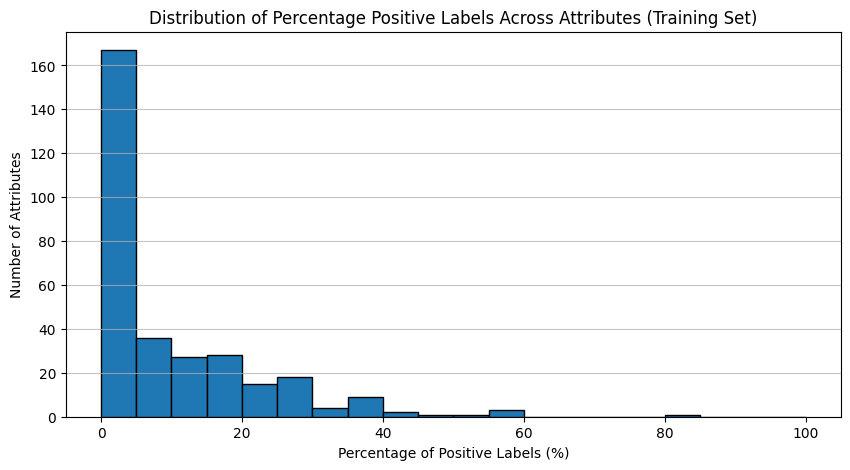


Analysis Complete.


In [13]:

# --- Plot Histogram of Percentage Positive ---
all_percent_pos = [stats['percent_pos'] for stats in attribute_imbalance_stats]

plt.figure(figsize=(10, 5))
plt.hist(all_percent_pos, bins=20, range=(0, 100), edgecolor='black')
plt.title('Distribution of Percentage Positive Labels Across Attributes (Training Set)')
plt.xlabel('Percentage of Positive Labels (%)')
plt.ylabel('Number of Attributes')
plt.grid(axis='y', alpha=0.75)
plt.show()

print("\nAnalysis Complete.")
# -------------------------------------------